# Neural Style Transfer With Keras

### Step 1 :- Importing Libraries

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16


from scipy.optimize import fmin_l_bfgs_b

### Step 2 :-  Preprocessing Of Image

In [0]:
# Height And Width Of The Image
height = 400
width = 400

In [0]:
# Preprocess Image
def preprocess(imagePath):
  
#   Open The Image
  image = Image.open(imagePath)
  
#   Resize The Image Using Given Height and Width
  image = image.resize((width, height))
  
#   Convert image Into Numpy array
  imageArray = np.asarray(image, dtype= 'float32')
  
#   Convert Image Array to 4D array
  imageArray = np.expand_dims(imageArray, axis=0)
  
#   Substract The mean RGB Value From the Image
  imageArray[:, :, :, 0] -= 103.939
  imageArray[:, :, :, 1] -= 116.779
  imageArray[:, :, :, 2] -= 123.68
  
#   Convert RGB Image to BGR
  imageArray = imageArray[:, :, :, ::-1]
  
#   Defining variables in keras backend-->tensorflow
  image = backend.variable(imageArray)
  
  return image

In [0]:
contentImage = preprocess('baby.jpg')

In [0]:
styleImage = preprocess('apple_sketch.jpg')

In [0]:
combinationImage = backend.placeholder((1, height, width, 3))

In [0]:
inputTensor = backend.concatenate([contentImage, styleImage, combinationImage], axis = 0)

### Step 3 :- Import Pretrained VGG16 Model

In [0]:
model = VGG16(input_tensor=inputTensor, weights='imagenet', include_top = False)
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [0]:
# Setting Up Hyperparameters
contentWeight = 0.025
styleWeight = 5.0
totalVariationWeight = 1.0

loss = backend.variable(0.)

### Step 4 :- Defining Three Loss Functions 


1.   Content Loss
2.   Style Loss
3.   Total Variation Loss



In [0]:
# Content Loss
def contentLoss(content, combination):
    return backend.sum(backend.square(combination - content))

layerFeatures = layers['block2_conv2']
contentImageFeatures = layerFeatures[0, :, :, :]
combinationImageFeatures = layerFeatures[2, :, :, :]

loss = loss + contentWeight * contentLoss(contentImageFeatures, combinationImageFeatures)

In [0]:
#The style loss
def gramMatrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def styleLoss(style, combination):
    S = gramMatrix(style)
    C = gramMatrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
  
featureLayers = ['block1_conv2', 'block2_conv2', 
                  'block3_conv3', 'block4_conv3', 
                  'block5_conv3'] 
for layerName in featureLayers:
  layerFeatures = layers[layerName]
  styleFeatures = layerFeatures[1, : ,: ,:]
  combinationFeatures = layerFeatures[2, :, :, :]
  sl = styleLoss(styleFeatures, combinationFeatures)
  loss += (styleWeight / len(featureLayers)) * sl

In [0]:
# Total Variation Loss
def totalVariationLoss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += totalVariationWeight * totalVariationLoss(combinationImage)


### Step 5 :- Compute Loss 

In [0]:
# Initialize The Gradient
grads = backend.gradients(loss, combinationImage)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combinationImage], outputs)

In [0]:
# Making Evaluator class that compute loss and gradient
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### Step 6 :- Training

In [102]:
# Initialize noise image
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    print('Iteration %d completed' % (i))


Start of iteration 0
Current loss value: 142166970000.0
Iteration 0 completed
Start of iteration 1
Current loss value: 57409890000.0
Iteration 1 completed
Start of iteration 2
Current loss value: 43084263000.0
Iteration 2 completed
Start of iteration 3
Current loss value: 38219473000.0
Iteration 3 completed
Start of iteration 4
Current loss value: 36341883000.0
Iteration 4 completed
Start of iteration 5
Current loss value: 35049910000.0
Iteration 5 completed
Start of iteration 6
Current loss value: 34363490000.0
Iteration 6 completed
Start of iteration 7
Current loss value: 33937447000.0
Iteration 7 completed
Start of iteration 8
Current loss value: 33614254000.0
Iteration 8 completed
Start of iteration 9
Current loss value: 33365250000.0
Iteration 9 completed


### Step 7 :- Display Final Results

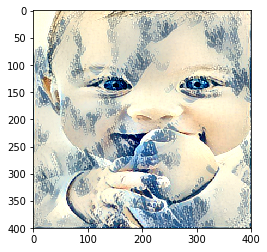

In [103]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

plt.imshow(x)